In [1]:
%run nb_header.py

Stata 17.0 (MP)


# Modeling Individual-Level CDC Data on COVID Deaths

Start with the [CDC Public Use data](https://data.cdc.gov/Case-Surveillance/COVID-19-Case-Surveillance-Public-Use-Data-with-Ge/ynhu-f2s2) downloaded on 2021-10-28, restricted to the period up through February 2021 (i.e., when the COVID Tracking Project stopped operating). Data preprocessing performed by [preprocess.py](../data/cdc/preprocess.py).

In [2]:
import pandas as pd
df = pd.read_feather('data/cdc/preprocessed.lz4')
df.head()

,case_month,res_state,age_group,sex,race,ethnicity,death_yn
0,2020-11,IN,0 - 17 years,NaN,NaN,NaN,No
1,2020-08,MI,18 to 49 years,NaN,NaN,NaN,No
2,2020-07,WI,18 to 49 years,NaN,NaN,NaN,Unknown
3,2020-12,KY,0 - 17 years,Female,NaN,NaN,NaN
4,2020-12,IL,0 - 17 years,Female,Missing,Missing,Missing


Drop states with no deaths or survivors, assumed to signal obvious reporting problems.

In [3]:
%%stata -d df -force -qui
gen month = monthly(case_month,"YM")
format month %tm
gen byte deceased = (death_yn=="Yes") if inlist(death_yn,"Yes","No")
egen cfr = mean(deceased), by(res_state)
drop if inlist(cfr,0,1,.)

Drop an additional 3 outliers plus ND which has no information on White, Black or Latinx cases, leaving us with 38 states.

In [4]:
%%stata -qui
preserve
keep res_state cfr
duplicates drop
noi sum cfr, det
noi li if cfr>0.5
restore
noi tab race if res_state=="ND", m
drop if inlist(res_state,"IL","RI","PR","ND")
encode res_state, gen(state)


                             cfr
-------------------------------------------------------------
      Percentiles      Smallest
 1%     .0025811       .0025811
 5%     .0029789       .0028438
10%     .0040208       .0029789       Obs                  42
25%     .0092379       .0032788       Sum of wgt.          42

50%     .0178277                      Mean           .0838265
                        Largest       Std. dev.       .204954
75%     .0435036       .1634144
90%     .1234509       .5080569       Variance       .0420061
95%     .5080569       .8390647       Skewness       3.513239
99%     .9836137       .9836137       Kurtosis       14.35867

     +---------------------+
     | res_st~e        cfr |
     |---------------------|
  5. |       IL   .9836137 |
 38. |       RI   .5080569 |
 42. |       PR   .8390647 |
     +---------------------+

                                  race |      Freq.     Percent        Cum.
---------------------------------------+--------------------

Recode covariates and collapse counts to improve performance when fitting model.

In [5]:
%%stata -qui
gen byte agegrp = 1 if age_group=="0 - 17 years"
replace agegrp = 2 if age_group=="18 to 49 years"
replace agegrp = 3 if age_group=="50 to 64 years"
replace agegrp = 4 if age_group=="65+ years"
gen byte female = (sex=="Female") if inlist(sex,"Male","Female")
gen byte ethgrp = 1 if race=="White" & ethnicity=="Non-Hispanic/Latino"
replace ethgrp = 2 if race=="Black"
replace ethgrp = 3 if ethnicity=="Hispanic/Latino" & mi(ethgrp)
contract res_state state month deceased agegrp female ethgrp, freq(deaths)
keep if inlist(deceased,0,1)
egen cases = total(deaths), by(res_state state month agegrp female ethgrp)
keep if deceased==1

Now we fit a Poisson model using the number of cases as the exposure and modeling the time trend using restricted cubic splines. Given our previous results based on the aggregate counts, we also include an interaction between age group and race/ethnicity. We start off with a base model not accounting for additional variability across states or across time within state. Part of the purpose here is to get a sense of what the standard errors look like when using the robust (sandwich) variance estimator, both unclustered and when clustered at the state level (n=38, unbalanced); as you can see, the biggest difference is when moving from the non-robust to the robust (i.e., relaxing the Poisson variance assumption) rather than when moving from the robust to the clustered.

In [6]:
%%stata -qui
mkspline time = month, cubic
noi mepoisson deaths i.agegrp##i.ethgrp i.female time*, exposure(cases) irr nolog
noi mepoisson deaths i.agegrp##i.ethgrp i.female time*, exposure(cases) irr vce(robust) nolog
noi mepoisson deaths i.agegrp##i.ethgrp i.female time*, exposure(cases) irr vce(cluster state) nolog


Poisson regression                              Number of obs     =      1,278

                                                Wald chi2(13)     =  124850.39
Log likelihood = -35956.198                     Prob > chi2       =     0.0000
-------------------------------------------------------------------------------
       deaths |        IRR   Std. err.      z    P>|z|     [95% conf. interval]
--------------+----------------------------------------------------------------
       agegrp |
           3  |   10.53167   .8408704    29.49   0.000     9.006074     12.3157
           4  |   104.5018   8.194758    59.29   0.000     89.61379    121.8633
              |
       ethgrp |
           2  |   6.036293   .5530917    19.62   0.000     5.044018    7.223771
           3  |   3.478262   .2841238    15.26   0.000     2.963681    4.082189
              |
agegrp#ethgrp |
         3 2  |   .4641255   .0438667    -8.12   0.000     .3856421    .5585814
         3 3  |   .6319995   .0532498    

Now we extend the model to account for additional variability at the state level as well as within state over time by incorporating hierarchical random effects. We use the cluster-robust variance estimator despite the relatively small number of clusters; this yields variance estimates that are reassuringly similar to what we achieved when fitting the random-effects model to the state-specific CFR ratios (see Cameron and Miller (2015) for discussion of the adequacy of this variance estimator with a small number of clusters).

In [7]:
%stata mepoisson deaths i.agegrp##i.ethgrp i.female time*, exposure(cases) vce(robust) irr || state: || month:


Fitting fixed-effects model:

Iteration 0:   log likelihood = -55209.979  
Iteration 1:   log likelihood =  -36123.39  
Iteration 2:   log likelihood = -35956.481  
Iteration 3:   log likelihood = -35956.198  
Iteration 4:   log likelihood = -35956.198  

Refining starting values:

Grid node 0:   log likelihood = -11220.108

Refining starting values (unscaled likelihoods):

Grid node 0:   log likelihood = -11208.589

Fitting full model:

Iteration 0:   log pseudolikelihood = -11208.589  (not concave)
Iteration 1:   log pseudolikelihood =  -11178.74  (not concave)
Iteration 2:   log pseudolikelihood = -11164.464  (not concave)
Iteration 3:   log pseudolikelihood = -11161.609  (not concave)
Iteration 4:   log pseudolikelihood = -11152.432  (not concave)
Iteration 5:   log pseudolikelihood = -11137.835  (not concave)
Iteration 6:   log pseudolikelihood = -11114.861  (not concave)
Iteration 7:   log pseudolikelihood = -11079.234  
Iteration 8:   log pseudolikelihood = -11059.114  
Iterati

The CFR ratios for race/ethnicity in the table above refer to the youngest age group in our analysis (18-49); we can compute the CFRs for the other age groups via simple linear combinations of the estimated coefficients. For example, here is the CFR ratio for Blacks compared to Whites, ages 50-64:

In [8]:
%stata lincom 2.ethgrp + 3.agegrp#2.ethgrp, irr


 ( 1)  [deaths]2.ethgrp + [deaths]3.agegrp#2.ethgrp = 0

------------------------------------------------------------------------------
      deaths |        IRR   Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
         (1) |   2.698971   .5904787     4.54   0.000     1.757815    4.144035
------------------------------------------------------------------------------


CFR ratio for Blacks compared to Whites, ages 65+

In [9]:
%stata lincom 2.ethgrp + 4.agegrp#2.ethgrp, irr


 ( 1)  [deaths]2.ethgrp + [deaths]4.agegrp#2.ethgrp = 0

------------------------------------------------------------------------------
      deaths |        IRR   Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
         (1) |   .9526762   .0667218    -0.69   0.489     .8304824    1.092849
------------------------------------------------------------------------------


CFR ratio for Hispanics compared to Whites, ages 50-64

In [10]:
%stata lincom 3.ethgrp + 3.agegrp#3.ethgrp, irr


 ( 1)  [deaths]3.ethgrp + [deaths]3.agegrp#3.ethgrp = 0

------------------------------------------------------------------------------
      deaths |        IRR   Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
         (1) |   2.389186   .5531177     3.76   0.000     1.517712    3.761063
------------------------------------------------------------------------------


CFR ratio for Hispanics compared to Whites, ages 65+

In [11]:
%stata lincom 3.ethgrp + 4.agegrp#3.ethgrp, irr


 ( 1)  [deaths]3.ethgrp + [deaths]4.agegrp#3.ethgrp = 0

------------------------------------------------------------------------------
      deaths |        IRR   Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
         (1) |    1.18104   .1052684     1.87   0.062     .9917343    1.406481
------------------------------------------------------------------------------


Here we generate and save the state-level random effects, so that we may plot them later on.

In [12]:
%%stata -qui
predict re*, reffects ebmeans reses(se*)
preserve
    keep res_state re1 se1
    duplicates drop
    isid res_state, so
    cap mkdir tmp
    export delim using tmp/state_effects.csv, replace
restore

Finally, we'll plot the estimated trend over time. Here we calculate the required margins and their corresponding confidence intervals.

In [13]:
%%stata -qui -ret margins
gen wgt = cases
replace cases = 1
margins [fw=wgt], expression(exp(predict(xb))) ///
         at(time1=720 time2=0 time3=0 time4=0) ///
         at(time1=721 time2=0 time3=0 time4=0) ///
         at(time1=722 time2=0 time3=0 time4=0) ///
         at(time1=723 time2=0.0082645 time3=0 time4=0) ///
         at(time1=724 time2=0.0661157 time3=0 time4=0) ///
         at(time1=725 time2=0.2231405 time3=0.0082645 time4=0) ///
         at(time1=726 time2=0.5289256 time3=0.0661157 time4=0) ///
         at(time1=727 time2=1.033058 time3=0.2231405 time4=0) ///
         at(time1=728 time2=1.785124 time3=0.5289256 time4=0) ///
         at(time1=729 time2=2.834711 time3=1.033058 time4=0.0082645) ///
         at(time1=730 time2=4.231405 time3=1.785124 time4=0.0661157) ///
         at(time1=731 time2=6.024794 time3=2.834711 time4=0.2231405) ///
         at(time1=732 time2=8.219008 time3=4.194215 time4=0.5082645) ///
         at(time1=733 time2=10.63636 time3=5.727273 time4=0.8677686) post

In [14]:
df = pd.DataFrame({'b':margins['r(table)'][0],
                   'll':margins['r(table)'][4],
                   'ul':margins['r(table)'][5],
                   'Month':pd.date_range('2019-12-01', periods=14, freq='M'),
                   'line_label':14*['Estimate'],
                   'area_label':14*['95% CI']}
                 )

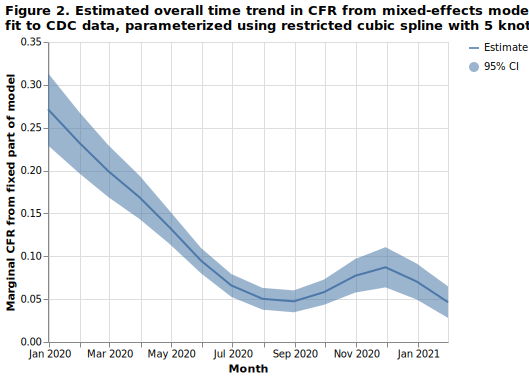

In [15]:
import altair as alt
alt.renderers.enable('svg')

line = alt.Chart(df).mark_line().encode(
    x=alt.X('Month:T', axis=alt.Axis(format='%b %Y')),
    y=alt.Y('b', title='Marginal CFR from fixed part of model'),
    color=alt.Color('line_label', title=None)
)
band = alt.Chart(df).mark_area(opacity=0.5).encode(
    x='Month:T',
    y='ll',
    y2='ul',
    opacity=alt.Opacity('area_label', sort=['95% CI'], title=None)
)

title = ['Figure 2. Estimated overall time trend in CFR from mixed-effects model','fit to CDC data, parameterized using restricted cubic spline with 5 knots']
fig2 = alt.layer(line, band, title=title).configure_title(anchor='start')
fig2.save('tmp/fig2.pdf')
fig2